<a href="https://colab.research.google.com/github/AV-BOLT/Stars_temp_prediction/blob/master/%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование температуры звезды

Целевой признак - Temperature (K)

## Загрузка данных и библиотек

In [465]:
import pandas as pd
import re
import torch.nn as nn
import torch
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

In [466]:
data = pd.read_csv('/content/drive/MyDrive/Projects_YP/нейронные сети 1 проект/6_class.csv')
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [467]:
data.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [468]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [469]:
RANDOM_STATE = 42

In [470]:
# Зададим константу для воспроизводимости результатов
torch.manual_seed(RANDOM_STATE)

In [471]:
np.random.seed(RANDOM_STATE)

In [472]:
# переименуем признаки
data.columns = ['temperature',
                'luminosity',
                'radius',
                'magnitude',
                'star_type',
                'star_color']

In [473]:
data.columns

Index(['temperature', 'luminosity', 'radius', 'magnitude', 'star_type',
       'star_color'],
      dtype='object')

## Исследовательский анализ

Проверим данные на типы данных и пропущенные значения.

In [474]:
data.shape

(240, 6)

In [475]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


В данных отсутствуют пропущенные значения.

Присутствуют числовые и один признак категориальный.




Проанализируем категориальный признак

In [476]:
categorical = data.select_dtypes(include = 'object').columns.to_list()
categorical

['star_color']

В признаке имеются неявные дубликаты.
Необходимо:
- привести к строчному регистру
- заменить "-" на "_"
- удалить пробелы

In [477]:
def transform_values(df):

   #удаляем пробелы в конце строк
    df = df.applymap(lambda x: x.rstrip())
     # заменяем пробелы на underscore

    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)

    # добавляем underscore между словом и числом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)

    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df

In [478]:
data[categorical] = transform_values(data[categorical])
data[categorical]

,star_color
0,red
1,red
2,red
3,red
4,red
...,...
235,blue
236,blue
237,white
238,white


In [479]:
list(data['star_color'].sort_values().unique())

['blue',
 'blue_white',
 'orange',
 'orange_red',
 'pale_yellow_orange',
 'red',
 'white',
 'white_yellow',
 'whitish',
 'yellow_white',
 'yellowish',
 'yellowish_white']

Дубликаты удалены.

In [480]:
data['star_color'].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

In [481]:
data.dtypes

temperature      int64
luminosity     float64
radius         float64
magnitude      float64
star_type        int64
star_color      object
dtype: object

In [482]:
data[['star_type','star_color' ]].value_counts(normalize = True)

star_type  star_color        
0          red                   0.166667
1          red                   0.166667
4          blue                  0.129167
5          red                   0.095833
3          blue_white            0.087500
2          blue_white            0.058333
           blue                  0.054167
4          red                   0.037500
2          white                 0.033333
3          yellow_white          0.033333
5          blue                  0.029167
           blue_white            0.025000
3          blue                  0.020833
2          yellowish_white       0.012500
3          yellowish             0.012500
5          orange                0.008333
           white                 0.008333
3          whitish               0.008333
2          white_yellow          0.004167
           pale_yellow_orange    0.004167
3          orange_red            0.004167
dtype: float64

## Анализ числовых признаков

In [483]:
numerical = data.select_dtypes(include = ('int', 'float', 'bool')).columns.to_list()

In [484]:
numerical =['luminosity', 'radius', 'magnitude', 'star_type']

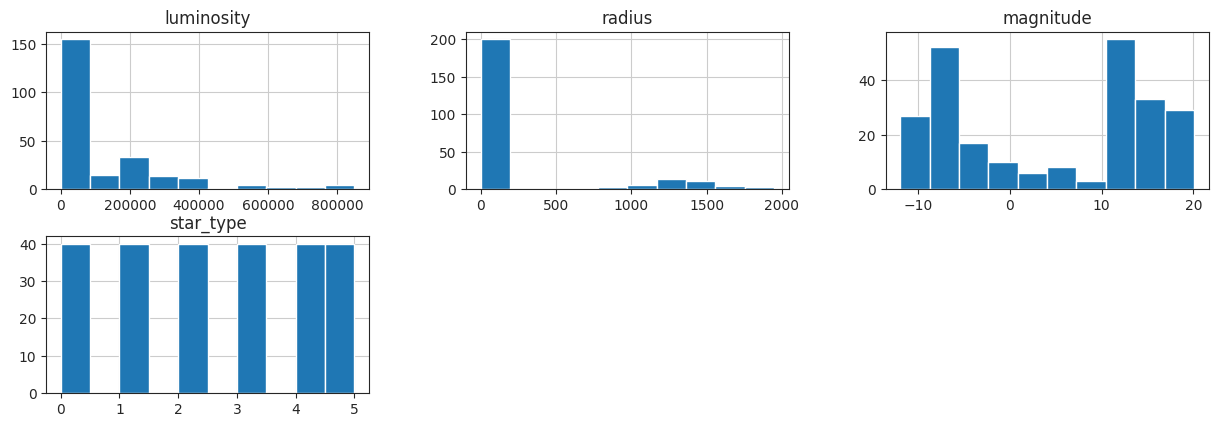

In [485]:
data[numerical].hist(layout = (4,3),
                     figsize=(15, 10));


Видим, что числовые значения имеют разный порядок, значит необходимо будет перед обучением подготовить признаки.

##Подготовка данных для модели

In [486]:
result = []

In [487]:
# функция для построения графика для результатов
def plot (y_test, test_outputs, name):

    #name это (название модели)

    fact_values = y_test.numpy().flatten()
    forecast_values = test_outputs.numpy().flatten()

    # в тестовом датасете 48 звезд, но дальше их может быть больше
    # поэтому ограничим
    indexes = test[y].index[:48]

    plt.figure(figsize=(8, 4))
    sns.set_style('ticks', {'axes.grid': True})

    # Создание столбчатой диаграммы для фактических значений
    fact_plot = sns.barplot(x = indexes,
                            y = fact_values,
                            color='blue',
                            alpha=0.9,
                            label='Факт')

    # Создание столбчатой диаграммы для прогнозов
    forecast_plot = sns.barplot(x=indexes,
                                y = forecast_values,
                                color='yellow',
                                alpha=0.7,
                                label='Прогноз')

    # Установка ширины столбцов и их позиции
    bar_width = 0.6

    for bar in fact_plot.patches + forecast_plot.patches:
        bar.set_width(bar_width)
        x = bar.get_x()
        bar.set_x(x + bar_width / 2)

    # Установка подписей осей и заголовка
    plt.xlabel('Номер звезды в таблице данных', fontweight='bold')

    plt.ylabel('Температура звезды', fontweight='bold')

    plt.title(f'{name}')

    plt.xticks(rotation=85)

    plt.yscale('log') # чтобы на графике можно
                       # было увидеть значения разных порядков

    # Создание и настройка легенды
    handles, labels = plt.gca().get_legend_handles_labels()

    handles.reverse()
    labels.reverse()
    plt.legend(handles,
               labels,
               bbox_to_anchor=(0.5, -0.25),
               loc='upper center',
               ncol=2)

    return plt.show()

In [488]:
X = data.drop('temperature', axis = 1).columns.to_list()
y = 'temperature'

### baseline_model

В качестве baseline модели будем использовать нейронную сеть следующей архитектуры:

|  Название параметра |кол-во|  
|---------------|-|
|Входной слой  (нейронов)|3|
|Скрытые слои   |2|
|Выходной слой  (нейронов)|1|
|Функция активации
в выходном слое |nn.ReLU() |

In [489]:
# неизменяемые параметры сети для всех моделей

hidden_neurons = 300

output_neurons = 1

loss = nn.MSELoss()

num_epochs = 10000

In [490]:
#преобразователь для признаков масштабирование и кодирование категориальных
column_transformer = ColumnTransformer(transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scale', StandardScaler(), numerical)])

In [491]:
class BaselineModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.act2 = nn.ReLU()

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        return x


In [492]:
#подготовим признаки для обучения
train, valid = train_test_split(data,
                                    test_size=0.4,
                                    shuffle=True,
                                    random_state=RANDOM_STATE)

valid, test = train_test_split(valid,
                               test_size=0.5,
                               shuffle=True,
                               random_state=RANDOM_STATE)

print('Размер обучающей выборки',train.shape)
print( )
print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (144, 6)

Размер валидационной выборки (48, 6)

Размер тестовой выборки (48, 6)


In [493]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print('Oбучающие признаки', X_train.size())
print()
print('Валидационные признаки', X_valid.size())
print()
print('Тестовые признаки', X_test.size())

Oбучающие признаки torch.Size([144, 14])

Валидационные признаки torch.Size([48, 14])

Тестовые признаки torch.Size([48, 14])


In [494]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

        outputs = model(X_train)

        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

        if (epoch + 1) % 1000 == 0:
          model.eval()  # Перевести модель в режим оценки
          with torch.no_grad():
              valid_outputs = model(X_valid)
              valid_loss = loss(valid_outputs, y_valid)
              print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')
print(f'Baseline Loss:  {np.sqrt(valid_loss)}')

Epoch [1000/10000], Loss: 21005686.0
Epoch [2000/10000], Loss: 15802203.0
Epoch [3000/10000], Loss: 14498485.0
Epoch [4000/10000], Loss: 13144420.0
Epoch [5000/10000], Loss: 11789995.0
Epoch [6000/10000], Loss: 10875456.0
Epoch [7000/10000], Loss: 9948285.0
Epoch [8000/10000], Loss: 9178509.0
Epoch [9000/10000], Loss: 8510856.0
Epoch [10000/10000], Loss: 8092293.5
Baseline Loss:  5117.5048828125


In [495]:
rmse_baseline = np.sqrt(valid_loss.item())
result.append(['rmse_baseline', rmse_baseline])
result

[['rmse_baseline', 5117.505056177278]]

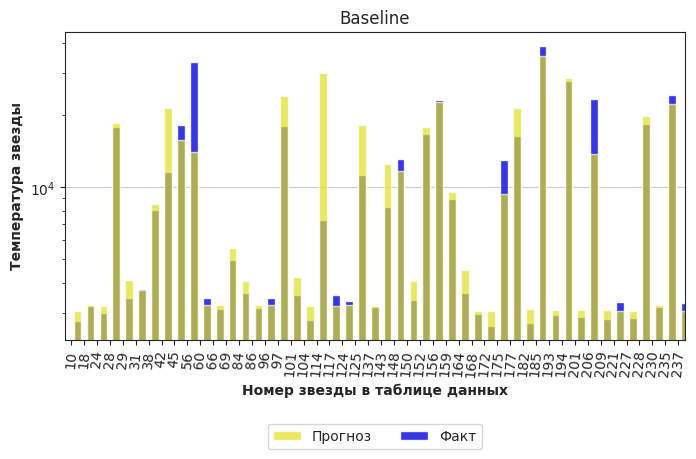

In [496]:
# строим график для визуализации предсказаний baseline модели
plot(y_valid, valid_outputs, 'Baseline')

## Улучшение модели

В задании к проекту нам дано обязательное требование
создать решение с перебором параметров нейросети:
- dropout
- размер батча.


Следующим этапом я проведу эксперимент с данными:
1.  создам синтетические данные и, обучив на них, получим предсказание на test выборке исходного датасета.
2. аугментирую исходный датасет (добавлю шум к числовым признакам) и, обучив на них, получим предсказание на test выборке исходного датасета.




### Подбор Dropout

In [497]:
class DropoutModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons, best_dropout):
        super(DropoutModel, self).__init__()

        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=best_dropout) # 50% dropout после первого слоя
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=best_dropout) # 50% dropout после второго слоя

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)  #  Dropout после первого слоя
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)  #  Dropout после второго слоя

        return x

In [498]:
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.6]

input_neurons = X_train.shape[1]

dropout_rmse = float('inf')
best_model = None
best_dropout = 0.5

for dropout in dropout_values:
  model = DropoutModel(input_neurons,
                       hidden_neurons,
                       output_neurons,
                       dropout)  # подбираем
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(num_epochs):
    outputs = model(X_train)
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        # Оценка модели на valid данных
        model.eval()  # оценка
        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

            # Оценка RMSE на valid данных
            rmse = np.sqrt(valid_loss.item())

            # Сравнение RMSE с лучшим результатом
            if rmse < dropout_rmse:
                dropout_rmse = rmse
                best_model = model
                best_dropout = dropout

Epoch [1000/10000], Loss: 38983780.0
Epoch [2000/10000], Loss: 15887819.0
Epoch [3000/10000], Loss: 14502803.0
Epoch [4000/10000], Loss: 13348248.0
Epoch [5000/10000], Loss: 11961604.0
Epoch [6000/10000], Loss: 10807954.0
Epoch [7000/10000], Loss: 9705354.0
Epoch [8000/10000], Loss: 8915673.0
Epoch [9000/10000], Loss: 8521187.0
Epoch [10000/10000], Loss: 8246122.0
Epoch [1000/10000], Loss: 62582884.0
Epoch [2000/10000], Loss: 16031239.0
Epoch [3000/10000], Loss: 14596141.0
Epoch [4000/10000], Loss: 13633409.0
Epoch [5000/10000], Loss: 11818914.0
Epoch [6000/10000], Loss: 10562896.0
Epoch [7000/10000], Loss: 9741394.0
Epoch [8000/10000], Loss: 8955824.0
Epoch [9000/10000], Loss: 8536307.0
Epoch [10000/10000], Loss: 8302801.0
Epoch [1000/10000], Loss: 57836552.0
Epoch [2000/10000], Loss: 16215143.0
Epoch [3000/10000], Loss: 14652951.0
Epoch [4000/10000], Loss: 13459947.0
Epoch [5000/10000], Loss: 11465054.0
Epoch [6000/10000], Loss: 10559822.0
Epoch [7000/10000], Loss: 9863020.0
Epoch [8

In [499]:
print(f'Лучший dropout_rmse: {dropout_rmse}')
print(f'Лучшие параметры: Dropout = {best_dropout}')

Лучший dropout_rmse: 4371.038549361009
Лучшие параметры: Dropout = 0.6


In [500]:
result.append(['dropout_rmse', dropout_rmse])
result

[['rmse_baseline', 5117.505056177278], ['dropout_rmse', 4371.038549361009]]

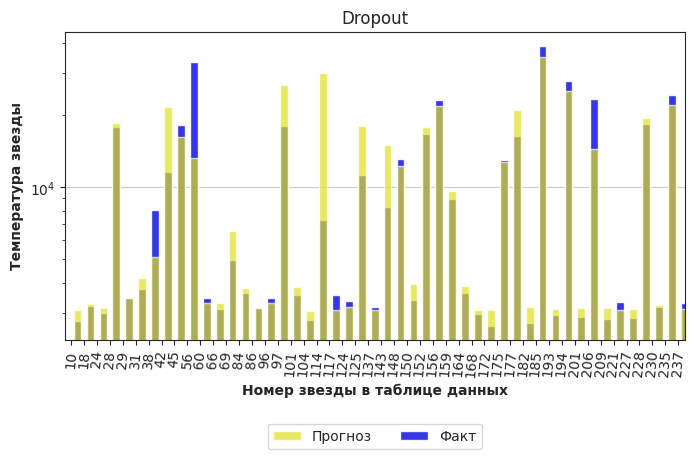

In [501]:
plot(y_valid, valid_outputs, 'Dropout')

  ### BatchSize

In [502]:
batch_sizes = [int(0.1*len(train)),
               int(0.3*len(train)),
               int(0.5*len(train))]

input_neurons = X_train.shape[1]

batch_sizes_rmse = float('inf')

best_batch_size = None

for batch_size in batch_sizes:

    # Создание и обучение модели
    model = BaselineModel(input_neurons, hidden_neurons, output_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            model.eval()
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

    # Оценка модели на валидационных данных
    with torch.no_grad():
        valid_outputs = model(X_valid)
        valid_loss = loss(valid_outputs, y_valid)
        rmse = np.sqrt(valid_loss.item())

    # Сравнение RMSE с лучшим результатом
    if rmse < batch_sizes_rmse:
        batch_sizes_rmse = rmse
        best_batch_size = batch_size

print(f'Best Batch Size: {best_batch_size}, Best RMSE: {best_rmse}')

Epoch [1000/10000], Loss: 21116654.0
Epoch [2000/10000], Loss: 15750873.0
Epoch [3000/10000], Loss: 14621258.0
Epoch [4000/10000], Loss: 13541979.0
Epoch [5000/10000], Loss: 12072727.0
Epoch [6000/10000], Loss: 10914624.0
Epoch [7000/10000], Loss: 9923690.0
Epoch [8000/10000], Loss: 9221806.0
Epoch [9000/10000], Loss: 8830153.0
Epoch [10000/10000], Loss: 8685449.0
Epoch [1000/10000], Loss: 20915872.0
Epoch [2000/10000], Loss: 15725918.0
Epoch [3000/10000], Loss: 14284584.0
Epoch [4000/10000], Loss: 12971461.0
Epoch [5000/10000], Loss: 11704022.0
Epoch [6000/10000], Loss: 10706110.0
Epoch [7000/10000], Loss: 9848983.0
Epoch [8000/10000], Loss: 9163587.0
Epoch [9000/10000], Loss: 8816438.0
Epoch [10000/10000], Loss: 8486198.0
Epoch [1000/10000], Loss: 21195158.0
Epoch [2000/10000], Loss: 15786802.0
Epoch [3000/10000], Loss: 14579974.0
Epoch [4000/10000], Loss: 13208826.0
Epoch [5000/10000], Loss: 11722875.0
Epoch [6000/10000], Loss: 10813669.0
Epoch [7000/10000], Loss: 10175628.0
Epoch [

In [503]:
for batch_size in batch_sizes:
    # Создание и обучение модели
    model = BaselineModel(input_neurons, hidden_neurons, output_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            model.eval()
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')
            # Оценка модели на валидационных данных
            with torch.no_grad():
                valid_outputs = model(X_valid)
                valid_loss = loss(valid_outputs, y_valid)
                rmse = np.sqrt(valid_loss.item())

    # Сравнение RMSE с лучшим результатом
    if rmse < best_rmse:
        best_rmse = rmse
        best_batch_size = batch_size

print(f'Best Batch Size: {best_batch_size}, Best RMSE: {best_rmse}')

Epoch [1000/10000], Loss: 21395824.0
Epoch [2000/10000], Loss: 15800171.0
Epoch [3000/10000], Loss: 14494837.0
Epoch [4000/10000], Loss: 13532444.0
Epoch [5000/10000], Loss: 12137013.0
Epoch [6000/10000], Loss: 10796304.0
Epoch [7000/10000], Loss: 9844010.0
Epoch [8000/10000], Loss: 8881897.0
Epoch [9000/10000], Loss: 8372250.5
Epoch [10000/10000], Loss: 7994036.5
Epoch [1000/10000], Loss: 21384170.0
Epoch [2000/10000], Loss: 15844284.0
Epoch [3000/10000], Loss: 14587763.0
Epoch [4000/10000], Loss: 13347122.0
Epoch [5000/10000], Loss: 11971824.0
Epoch [6000/10000], Loss: 10934265.0
Epoch [7000/10000], Loss: 10063838.0
Epoch [8000/10000], Loss: 9385188.0
Epoch [9000/10000], Loss: 8944640.0
Epoch [10000/10000], Loss: 8665934.0
Epoch [1000/10000], Loss: 21032502.0
Epoch [2000/10000], Loss: 15880581.0
Epoch [3000/10000], Loss: 14576710.0
Epoch [4000/10000], Loss: 13059709.0
Epoch [5000/10000], Loss: 11740351.0
Epoch [6000/10000], Loss: 10937552.0
Epoch [7000/10000], Loss: 10282207.0
Epoch 

In [504]:
model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [505]:
print(f'Лучший batch_sizes_rmse: {batch_sizes_rmse}')
print(f'Лучшие параметры:  Batch Size = {best_batch_size}')

Лучший batch_sizes_rmse: 5048.604361603313
Лучшие параметры:  Batch Size = 43


In [506]:
result.append(['batch_sizes_rmse', batch_sizes_rmse])
result

[['rmse_baseline', 5117.505056177278],
 ['dropout_rmse', 4371.038549361009],
 ['batch_sizes_rmse', 5048.604361603313]]

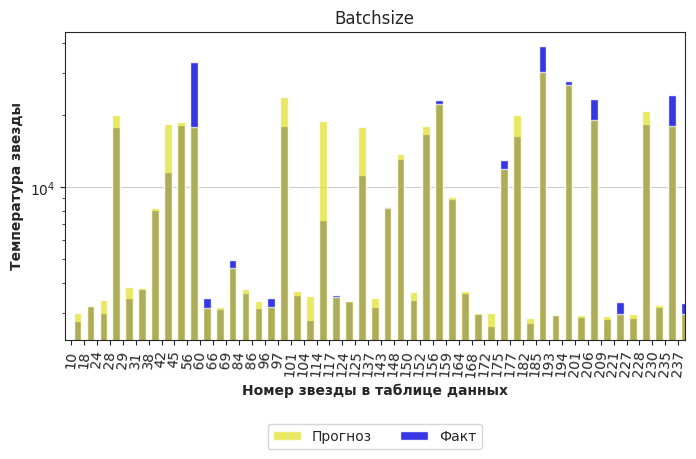

In [542]:
plot(y_valid, valid_outputs, 'Batchsize')

### Аугментация данных

Метрику мы будем сравнивать на baseline модели, предсказывая по test выборке исходного датасета.

###Синтетическая Генерация Данных

Ниже приведена таблица с диапазонами характеристик для каждой звезды, мы будем создавать новые данные используя эту таблицу.

| Температура (K) | Светимость (L/Lo) | Радиус (R/Ro) | Абсолютная звёздная величина (Mv) | Тип звезды | Цвет звезды |
|-----------------|-------------------|---------------|------------------------------------|------------|-------------|
| ~2,000 K        | 0.00001% - 0.1%   | 0.1 - 0.7     | Высокая отрицательная              | M (красные карлики) | Красные, оранжевые |
| ~3,500 K        | 1% - 10%           | 0.7 - 1.0     | Низкая отрицательная               | K | Оранжевые, красные |
| Очень высокая  | Очень низкая       | Сравним с Землёй | Высокая отрицательная | Белые карлики | Белые |
| ~5,500 K        | 100%               | 1.0           | 4.83                               | G (похожие на Солнце) | Желтые |
| ~10,000 K - несколько десятков тысяч K | >100 - несколько тысяч | >1 - несколько сотен | Низкая отрицательная | Горячие звёзды | Голубые, белые |
| ~2,000 K - 1,000 K (обычно ниже) | Очень низкая - очень очень низкая | 0.01 - 0.1 (примерно) | Высокая отрицательная | Коричневые карлики | Коричневые |
| Разнообразная  | Очень высокая - низкая | Разнообразный | Разнообразная | Гиганты (разных классов) | Разноцветные |
| Разнообразная  | Очень высокая - низкая | Разнообразный | Разнообразная | Сверхгиганты | Разноцветные |
| ~5,500 K        | Около 100%         | Около 1.0     | 4.83 | Звёзды главной последовательности | Желтые |


In [512]:
data['star_color'].value_counts(normalize = True)

red                   0.466667
blue                  0.233333
blue_white            0.170833
white                 0.041667
yellow_white          0.033333
yellowish_white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale_yellow_orange    0.004167
white_yellow          0.004167
orange_red            0.004167
Name: star_color, dtype: float64

In [551]:
synthetic_data = []

n_samples = 200  # Общее количество сэмплов

# Генерация данных для красных карликов (M-тип)
n_samples_m = int(n_samples * 0.45)
temperature_m = np.random.uniform(2000, 3500, n_samples_m)
luminosity_m = np.random.uniform(0.00001, 0.1, n_samples_m)
radius_m = np.random.uniform(0.1, 0.7, n_samples_m)
magnitude_m = np.random.uniform(-11.92, -6.23, n_samples_m)
star_type_m = [0] * n_samples_m  # добавляем тип звезды (0-6)
star_color_m = ['red'] * n_samples_m

# Генерация данных для оранжевых карликов (K-тип)
n_samples_k = int(n_samples * 0.151)
temperature_k = np.random.uniform(3500, 5500, n_samples_k)
luminosity_k = np.random.uniform(0.01, 0.1, n_samples_k)
radius_k = np.random.uniform(0.7, 1.0, n_samples_k)
magnitude_k = np.random.uniform(-6.23, -2, n_samples_k)
star_type_k = [1] * n_samples_k
star_color_k = ['orange'] * n_samples_k

# Генерация данных для белых карликов (группа "Очень высокая")
n_samples_wd = int(n_samples * 0.16)
temperature_wd = np.random.uniform(5500, 6000, n_samples_wd)
luminosity_wd = np.random.uniform(0.99, 1.01, n_samples_wd)
radius_wd = np.random.uniform(0.99, 1.01, n_samples_wd)
magnitude_wd = np.full(n_samples_wd, 4.83)
star_type_wd = [2] * n_samples_wd
star_color_wd = ['white'] * n_samples_wd

# Генерация данных для звёзд главной последовательности (G-тип)
n_samples_g = int(n_samples * 0.09)
temperature_g = np.random.uniform(5500, 5700, n_samples_g)
luminosity_g = np.random.uniform(0.99, 1.01, n_samples_g)
radius_g = np.random.uniform(0.99, 1.01, n_samples_g)
magnitude_g = np.full(n_samples_g, 4.83)
star_type_g = [3] * n_samples_g
star_color_g = ['yellow'] * n_samples_g

# Генерация данных для горячих звёзд
n_samples_hot = int(n_samples * 0.3)
temperature_hot = np.random.uniform(10000, 30000, n_samples_hot)
luminosity_hot = np.random.uniform(100, 3000, n_samples_hot)
radius_hot = np.random.uniform(10, 100, n_samples_hot)
magnitude_hot = np.random.uniform(-11.92, -6.23, n_samples_hot)
star_type_hot = [4] * n_samples_hot
star_color_hot = ['blue'] * n_samples_hot

# Генерация данных для коричневых карликов (L-тип)
n_samples_l = int(n_samples * 0.06)
temperature_l = np.random.uniform(1000, 2000, n_samples_l)
luminosity_l = np.random.uniform(0.00000001, 0.0000001, n_samples_l)
radius_l = np.random.uniform(0.01, 0.1, n_samples_l)
magnitude_l = np.random.uniform(-11.92, -6.23, n_samples_l)
star_type_l = [5] * n_samples_l
star_color_l = ['blue_white'] * n_samples_l

# создаем новый df
synthetic_data = pd.DataFrame({
    'temperature': np.concatenate((temperature_m,
                                   temperature_k,
                                   temperature_wd,
                                   temperature_g,
                                   temperature_hot,
                                   temperature_l)),

    'luminosity': np.concatenate((luminosity_m,
                                  luminosity_k,
                                  luminosity_wd,
                                  luminosity_g,
                                  luminosity_hot,
                                  luminosity_l)),

    'radius': np.concatenate((radius_m,
                              radius_k,
                              radius_wd,
                              radius_g,
                              radius_hot,
                              radius_l)),

    'magnitude': np.concatenate((magnitude_m,
                                 magnitude_k,
                                 magnitude_wd,
                                 magnitude_g,
                                 magnitude_hot,
                                 magnitude_l)),

    'star_type': np.concatenate((star_type_m,
                                 star_type_k,
                                 star_type_wd,
                                 star_type_g,
                                 star_type_hot,
                                 star_type_l)),

    'star_color': np.concatenate((star_color_m,
                                  star_color_k,
                                  star_color_wd,
                                  star_color_g,
                                  star_color_hot,
                                  star_color_l))
})

# перемешиваем
synthetic_data = synthetic_data.sample(frac=1).reset_index(drop=True)

In [514]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  242 non-null    float64
 1   luminosity   242 non-null    float64
 2   radius       242 non-null    float64
 3   magnitude    242 non-null    float64
 4   star_type    242 non-null    int64  
 5   star_color   242 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 11.5+ KB


In [515]:
synthetic_data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,242.000000,2.420000e+02,242.000000,242.000000,242.000000
mean,7877.899892,4.236942e+02,14.917867,-5.590080,1.851240
std,7834.761749,8.467344e+02,28.578892,5.729506,1.764854
min,1054.383946,1.256717e-08,0.015779,-11.868660,0.000000
25%,2811.784839,3.859955e-02,0.397087,-9.876220,0.000000
50%,4611.486844,8.897588e-02,0.883914,-7.664463,2.000000
75%,5988.820337,1.009767e+00,1.009755,-3.875316,4.000000
max,28758.062445,2.974519e+03,99.969889,4.830000,5.000000


In [516]:
data['star_color'].value_counts(normalize = True)

red                   0.466667
blue                  0.233333
blue_white            0.170833
white                 0.041667
yellow_white          0.033333
yellowish_white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale_yellow_orange    0.004167
white_yellow          0.004167
orange_red            0.004167
Name: star_color, dtype: float64

#### модель на синт данных

In [517]:
train = synthetic_data
valid = valid

In [518]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())

torch.Size([242, 10])

torch.Size([48, 10])


In [519]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                      hidden_neurons,
                      output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [520]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки

        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

        print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/10000], Loss: 9095437.0
Valid Loss: 487572.6159988889
Epoch [2000/10000], Loss: 7914865.0
Valid Loss: 368072.39635702106
Epoch [3000/10000], Loss: 7847739.0
Valid Loss: 360458.4998470698
Epoch [4000/10000], Loss: 7832487.0
Valid Loss: 358710.52833168977
Epoch [5000/10000], Loss: 7819273.5
Valid Loss: 357079.1317117258
Epoch [6000/10000], Loss: 7791923.0
Valid Loss: 354905.28169639857
Epoch [7000/10000], Loss: 7746976.5
Valid Loss: 355269.81656200404
Epoch [8000/10000], Loss: 7710831.0
Valid Loss: 390292.90596678795
Epoch [9000/10000], Loss: 7679897.5
Valid Loss: 440923.7906758945
Epoch [10000/10000], Loss: 7572229.5
Valid Loss: 572814.4874145555


In [521]:
np.sqrt(valid_loss.item())

572814.4874145555

In [522]:
rmse_synthetic = np.sqrt(valid_loss.item())
result.append(['rmse_synthetic', rmse_synthetic])
result

[['rmse_baseline', 5117.505056177278],
 ['dropout_rmse', 4371.038549361009],
 ['batch_sizes_rmse', 5048.604361603313],
 ['rmse_best_model', 10194.582090502778],
 ['rmse_synthetic', 572814.4874145555]]

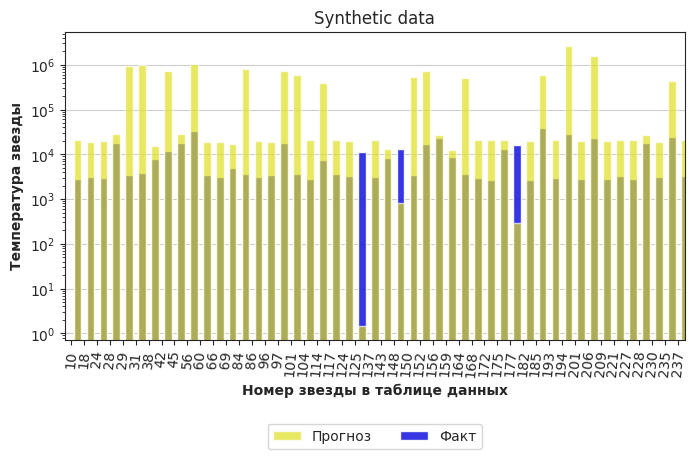

In [523]:
plot(y_valid, valid_outputs, 'Synthetic data')

### Аугментация данных на основе исходного датасета

In [524]:
numerical

['luminosity', 'radius', 'magnitude', 'star_type']

In [525]:
augmented_data = data.copy()

# числовые признаки, к которым добавляем шум
numeric_features = ['luminosity', 'radius', 'magnitude']

# значения шума
noise_mean = 0  # Среднее значение шума
noise_std = 0.05  # Стандартное отклонение шума

for numeric_feature in numeric_features:
    random_noise = np.random.normal(noise_mean, noise_std, len(data))
    augmented_data[numeric_feature] += random_noise

    # контролируем разброс min max значений
    augmented_data[numeric_feature] = np.clip(augmented_data[numeric_feature],
                                              data[numeric_feature].min(),
                                              data[numeric_feature].max())

# Создайте новый DataFrame для аугментированных данных
augmented_data.head()


,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.031248,0.165925,16.084094,0,red
1,3042,0.044943,0.131592,16.653545,0,red
2,2600,0.011720,0.032469,18.768920,0,red
3,2800,0.060800,0.144025,16.632907,0,red
4,1939,0.000080,0.164166,20.060000,0,red


In [526]:
augmented_data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.374132,237.160601,4.376958,2.500000
std,9552.425037,179432.241903,517.152228,10.538022,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.001643,0.103728,-6.244016,1.000000
50%,5776.000000,0.142049,0.806028,8.260070,2.500000
75%,15055.500000,198050.032196,42.755176,13.731308,4.000000
max,40000.000000,849420.000000,1948.452243,20.060000,5.000000


In [527]:
data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


####модель на аугментированном датасете с шумом

In [528]:
train = augmented_data
valid = valid

In [529]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)


print(X_train.size())
print()
print(X_valid.size())
print()


torch.Size([240, 16])

torch.Size([48, 16])



In [530]:
input_neurons = X_train.shape[1]


model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

In [531]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки
        with torch.no_grad():
          valid_outputs = model(X_valid)
          valid_loss = loss(valid_outputs, y_valid)
          print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [2000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [3000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [4000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [5000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [6000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [7000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [8000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [9000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573
Epoch [10000/10000], Loss: 201063488.0
Valid Loss: 13002.70494935573


In [532]:
rmse_augmented = np.sqrt(valid_loss.item())
result.append(['rmse_augmented', rmse_augmented])
result

[['rmse_baseline', 5117.505056177278],
 ['dropout_rmse', 4371.038549361009],
 ['batch_sizes_rmse', 5048.604361603313],
 ['rmse_best_model', 10194.582090502778],
 ['rmse_synthetic', 572814.4874145555],
 ['rmse_augmented', 13002.70494935573]]

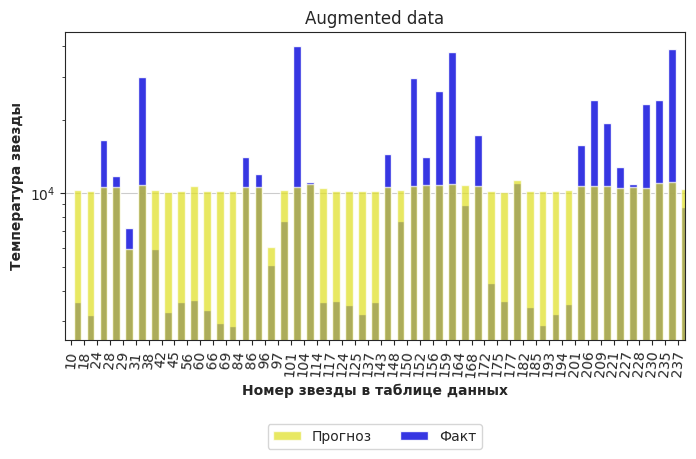

In [533]:
plot(y_test, test_outputs, 'Augmented data')

#### модель на 2-x датасетах

In [534]:
data_concat2 = pd.concat([augmented_data,
                          synthetic_data],
                         ignore_index = True)

In [535]:
train = data_concat2
valid = valid

In [536]:
print('Размер обучающей выборки',train.shape)
print ()
print('Размер валидационной выборки', valid.shape)

Размер обучающей выборки (482, 6)

Размер валидационной выборки (48, 6)


In [537]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]).toarray())
X_valid = torch.Tensor(column_transformer.transform(valid[X]).toarray())

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())


torch.Size([482, 17])

torch.Size([48, 17])


In [538]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [539]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки

        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/10000], Loss: 22144048.0
Epoch [2000/10000], Loss: 17666034.0
Epoch [3000/10000], Loss: 15173116.0
Epoch [4000/10000], Loss: 13971649.0
Epoch [5000/10000], Loss: 13548407.0
Epoch [6000/10000], Loss: 13280601.0
Epoch [7000/10000], Loss: 12833667.0
Epoch [8000/10000], Loss: 12547144.0
Epoch [9000/10000], Loss: 12234729.0
Epoch [10000/10000], Loss: 12004652.0
Valid Loss: 3725.5755260093706


In [540]:
rmse_concat2 = np.sqrt(valid_loss.item())
result.append(['rmse_concat2', rmse_concat2])
result

[['rmse_baseline', 5117.505056177278],
 ['dropout_rmse', 4371.038549361009],
 ['batch_sizes_rmse', 5048.604361603313],
 ['rmse_best_model', 10194.582090502778],
 ['rmse_synthetic', 572814.4874145555],
 ['rmse_augmented', 13002.70494935573],
 ['rmse_concat2', 3725.5755260093706]]

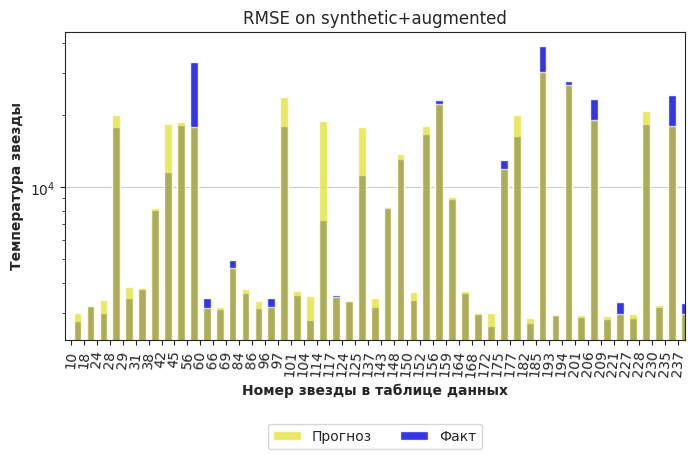

In [541]:
plot(y_valid, valid_outputs, 'RMSE on synthetic+augmented')

#### Модель на 3 датасетах

In [544]:
data_concat3 = pd.concat([data,
                          augmented_data,
                          synthetic_data],
                         ignore_index = True)

In [545]:
train, valid = train_test_split(data_concat3,
                                test_size = 0.4,
                                shuffle=True,
                                random_state = RANDOM_STATE)
print('Размер обучающей выборки',train.shape)

valid, test = train_test_split(valid,
                               test_size = 0.5,
                               shuffle=True,
                                random_state = RANDOM_STATE)

print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (433, 6)
Размер валидационной выборки (144, 6)

Размер тестовой выборки (145, 6)


In [547]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]).toarray())
X_valid = torch.Tensor(column_transformer.transform(valid[X]).toarray())
X_test = torch.Tensor(column_transformer.transform(test[X]).toarray())


y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())

torch.Size([433, 17])

torch.Size([144, 17])

torch.Size([145, 17])


In [548]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                      hidden_neurons,
                      output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [549]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки
        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/10000], Loss: 21430528.0
Epoch [2000/10000], Loss: 16682923.0
Epoch [3000/10000], Loss: 14275452.0
Epoch [4000/10000], Loss: 12805513.0
Epoch [5000/10000], Loss: 12003282.0
Epoch [6000/10000], Loss: 11615849.0
Epoch [7000/10000], Loss: 11350702.0
Epoch [8000/10000], Loss: 11026472.0
Epoch [9000/10000], Loss: 10525140.0
Epoch [10000/10000], Loss: 10165565.0
Valid Loss: 5195.422793190175


In [550]:
rmse_concat3 = np.sqrt(valid_loss.item())
result.append(['rmse_concat3', rmse_concat3])
result

[['rmse_baseline', 5117.505056177278],
 ['dropout_rmse', 4371.038549361009],
 ['batch_sizes_rmse', 5048.604361603313],
 ['rmse_best_model', 10194.582090502778],
 ['rmse_synthetic', 572814.4874145555],
 ['rmse_augmented', 13002.70494935573],
 ['rmse_concat2', 3725.5755260093706],
 ['batch_sizes_rmse', 5048.604361603313],
 ['rmse_concat3', 5195.422793190175]]

## Финальная модель

По результатам исследования мы получили данные, что все манипуляции уменьшали rmse модели, поэтому сейчас мы соберем модель и выясним метрику.
- Dropout
- batchsize
- аугментация

Учитывая, что датасеты у нас тоже менялись, я найду еще раз лучший размер батча.

In [556]:
train, valid = train_test_split(data_concat2,
                                test_size = 0.4,
                                shuffle=True,
                                random_state = RANDOM_STATE)
print('Размер обучающей выборки',train.shape)

valid, test = train_test_split(valid,
                               test_size = 0.5,
                               shuffle=True,
                                random_state = RANDOM_STATE)

print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (289, 6)
Размер валидационной выборки (96, 6)

Размер тестовой выборки (97, 6)


In [558]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))


y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())

torch.Size([289, 16])

torch.Size([96, 16])

torch.Size([97, 16])


In [568]:
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.6]
best_dropout = 0.5
best_model = None
batch_sizes = [int(0.1 * len(X_train)),
               int(0.3 * len(X_train)),
               int(0.5 * len(X_train))]

best_rmse = float('inf')
best_batch_size = None

input_neurons = X_train.shape[1]
model = DropoutModel(input_neurons, hidden_neurons, output_neurons, best_dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for dropout in dropout_values:
    for batch_size in batch_sizes:
        model = DropoutModel(input_neurons, hidden_neurons, output_neurons, dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(num_epochs):
            outputs = model(X_train)
            loss_train = loss(outputs, y_train)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if (epoch + 1) % 5000 == 0:
                model.eval()
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

                with torch.no_grad():
                    valid_outputs = model(X_valid)
                    valid_loss = loss(valid_outputs, y_valid)
                    rmse = np.sqrt(valid_loss.item())

        if rmse < best_rmse:
            best_rmse = rmse
            best_batch_size = batch_size
            best_dropout = dropout
            best_model = model


print(f'Best Batch Size: {best_batch_size}, Best RMSE: {best_rmse}, Best Dropout: {best_dropout}')

Epoch [5000/10000], Loss: 26981674.0
Epoch [10000/10000], Loss: 12175218.0
Epoch [5000/10000], Loss: 31172608.0
Epoch [10000/10000], Loss: 12266205.0
Epoch [5000/10000], Loss: 23692950.0
Epoch [10000/10000], Loss: 11873808.0
Epoch [5000/10000], Loss: 39766968.0
Epoch [10000/10000], Loss: 12213372.0
Epoch [5000/10000], Loss: 45957252.0
Epoch [10000/10000], Loss: 12064646.0
Epoch [5000/10000], Loss: 29728832.0
Epoch [10000/10000], Loss: 12176932.0
Epoch [5000/10000], Loss: 64533268.0
Epoch [10000/10000], Loss: 12425381.0
Epoch [5000/10000], Loss: 58519740.0
Epoch [10000/10000], Loss: 12231352.0
Epoch [5000/10000], Loss: 67279872.0
Epoch [10000/10000], Loss: 12479237.0
Epoch [5000/10000], Loss: 82942896.0
Epoch [10000/10000], Loss: 10760948.0
Epoch [5000/10000], Loss: 62949668.0
Epoch [10000/10000], Loss: 12273786.0
Epoch [5000/10000], Loss: 72220704.0
Epoch [10000/10000], Loss: 12569233.0
Epoch [5000/10000], Loss: 113273616.0
Epoch [10000/10000], Loss: 12814194.0
Epoch [5000/10000], Loss

In [569]:
# оцениваем
best_model.eval()

# Прогон X_test через модель
with torch.no_grad():
    test_outputs = best_model(X_test)
    test_loss = loss(test_outputs, y_test)

# Оценка RMSE (если целевые значения и предсказания имеют одинаковые формы)
rmse_test = np.sqrt(test_loss.item())

print(f'RMSE on Test Data: {rmse_test}')


RMSE on Test Data: 4266.430358039376


4326.859369103646


## Вывод